In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import U1,U2,U3 #IBMQの基底ゲート

from fractions import Fraction

## 理想的な回路作成

In [2]:
# 係数の絶対値の分布をプロットする関数
def show_distribution(state, nqubits):
    plt.bar([i for i in range(pow(2, nqubits))], abs(state.get_vector()))
    plt.xlabel('$2^5$個のデータ')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.show()

###　動作の確認
初期状態$|0 \cdots 0\rangle$を作成

In [3]:
# 全体のパラメータ
nqubits = 3
times = 4

In [4]:
import matplotlib.ticker as ticker
state1 = QuantumState(nqubits)
state1.set_zero_state()

次にアダマールゲートを作成する
$$
H = \frac{1}{\sqrt{2}}(|0\rangle \langle 0 | + |1\rangle \langle 0| + |0\rangle \langle 1| + |1\rangle \langle 1|)
$$

In [5]:
def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return  Hadamard

このアダマールゲートを初期状態$|00 \cdots 00\rangle$に作用させる。
$$
|s\rangle = (H\otimes \cdots \otimes H)|0 \cdots 0 \rangle \\
= \frac{1}{(\sqrt{2})^n}(|0\rangle + |1\rangle)\otimes \cdots \otimes (|0\rangle + |1\rangle) \\
= \frac{1}{(\sqrt{2})^n}(|00 \cdots 00\rangle + |00\cdots 01\rangle + \cdots + |11 \cdots 10\rangle + |11\cdots 11\rangle)|s\rangle \\
= \frac{1}{(\sqrt{2})^n}\sum^{2^n - 1}_{x = 0} |x\rangle
$$

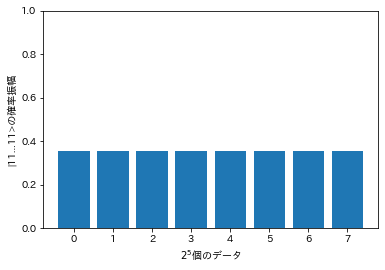

In [6]:
Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state1)

show_distribution(state1, nqubits)

次に解に対する反転操作をする、オラクル$U_w$を作成する。

入力$|x\rangle$に対して$x$が解なら、$-1$を掛けて位相を反転し、解でないなら$1$を掛ける。

$$
\begin{cases}
    U_w|x\rangle = |x\rangle (x \neq w) \\
    U_w|w\rangle = -|w\rangle
  \end{cases}
$$

$$
U_w = I - 2 \sum_{w \in \text{解}} |w\rangle \langle w|
$$

In [7]:
# オラクルU_wの作成
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits-1))
    # i-th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

これを作用させると$|s\rangle$
$$
U_w |s\rangle = \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} U_w |x\rangle + \frac{1}{(\sqrt{2})^n} U_w |x\rangle \\

= \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} |x\rangle - \frac{1}{(\sqrt{2})^n}|w\rangle \\

= \left( |s\rangle - \frac{1}{(\sqrt{2})^n} |w\rangle \right) - \frac{1}{(\sqrt{2})^n} |w\rangle \\

U_w |s\rangle = |s\rangle - \frac{2}{(\sqrt{2})^n} |w\rangle
$$

となる。

In [8]:
fuga = state1.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(fuga)
# print(fuga.get_vector())
print(fuga)

 *** Quantum State ***
 * Qubit Count : 3
 * Dimension   : 8
 * State vector : 
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
(-0.353553,0)



最後に$|s\rangle$を対象軸にした反転操作$U_s$を定義する

$$
U_s = 2|s\rangle \langle s| - I = H^{\otimes n}(2 |0 \cdots 0\rangle \langle 0 \cdots 0| - I)H^{\otimes n}
$$

$$
\begin{cases}
    U_s |x\rangle = 2\langle s|x|s\rangle - |x\rangle = \frac{2}{\sqrt{2^n}} |x\rangle \\
    U_s |s\rangle = 2\langle s|s|s\rangle - |s\rangle = |s\rangle
 \end{cases}
$$

In [9]:
# 反転U_sを作る
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
    U_s.add_gate( X(nqubits-1) )
    ## 全てのi-th qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) )

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

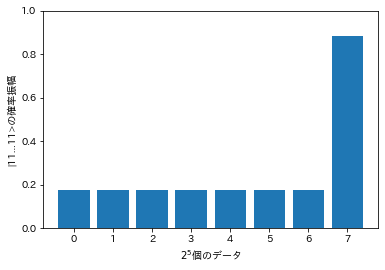

In [10]:
## 初期状態の準備
state1 = QuantumState(nqubits)
state1.set_zero_state()
Hadamard.update_quantum_state(state1)

## U_s U_w を作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state1)
U_s.update_quantum_state(state1)
show_distribution(state1, nqubits)

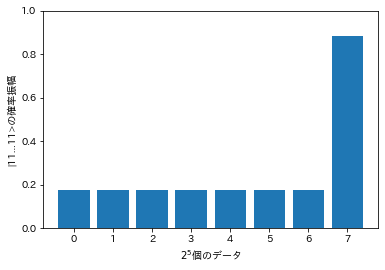

0.8838834764831837


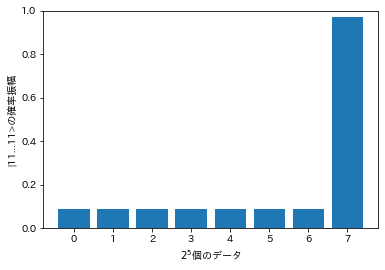

0.9722718241315015


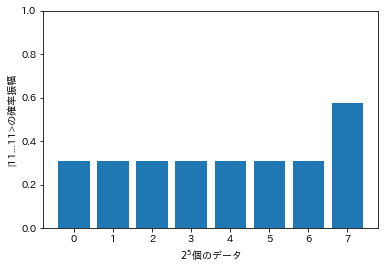

0.5745242597140687


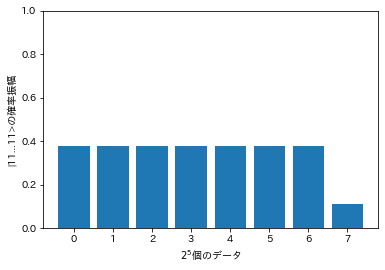

0.11048543456039785


In [11]:
# 何回か繰り返す
## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
state1 = QuantumState(nqubits)
state1.set_zero_state()

Hadamard.update_quantum_state(state1)

avg_result = []
for i in range(4):
    U_w.update_quantum_state(state1)
    U_s.update_quantum_state(state1)
    show_distribution(state1, nqubits)
    fuga = np.linalg.norm(inner_product(state1, target_state))
    avg_result.append(fuga)
    print(fuga)

0.8838834764831837
0.9722718241315015
0.5745242597140687
0.11048543456039785


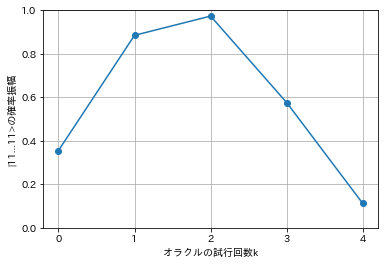

In [12]:
## 初期状態の準備
state1 = QuantumState(nqubits)
state1.set_zero_state()
Hadamard.update_quantum_state(state1)

avg_result = []
hoge = np.linalg.norm(inner_product(state1, target_state))
avg_result.append(hoge)
for i in range(times):
    U_w.update_quantum_state(state1)
    U_s.update_quantum_state(state1)
    fuga = np.linalg.norm(inner_product(state1, target_state))
    avg_result.append(fuga)
    print(fuga)

plt.xlabel('オラクルの試行回数k')
plt.ylabel('|11...11>の確率振幅')
plt.ylim(0, 1)
plt.xticks(np.arange(0, len(avg_result), step=1))
plt.grid()
plt.plot(avg_result, "o-")

In [13]:
def line_graph(result, title):
    plt.title(title)
    plt.plot(result, "o-")
    plt.xlabel('オラクルの試行回数k')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, len(result), step=1))
    plt.grid()
    plt.show()


In [14]:
# グローバーのアルゴリズム
def grover(nqubits, operate_times):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')
    return  result, max_k, result[max_k]

maximal probability 9.722718e-01 is obtained at k = 2


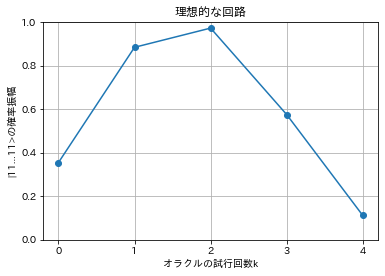

In [15]:
result_array = []
result_theory, k_theory, p_kth= grover(nqubits, times)
line_graph(result_theory, '理想的な回路')

## 任意の回転ゲート
任意の回転ゲートでアダマール演算子を作成する

Qulacsでは任意の回転ゲートを作成する際に、IBMQのOpenQASMを使用する。

以下のコードは、
`U3(対象ビットの添字, \theta, \psi, \lambda)`となっている。
[参考資料](http://docs.qulacs.org/ja/latest/guide/2.0_python_advanced.html#id24)
また、対象ビットの添字はQulacsの仕様上、$|00 \cdots 00\rangle$である場合、一番右から0番目の量子ビットになる
[参考資料](https://docs.qulacs.org/ja/latest/intro/4.1_python_tutorial.html?highlight=%E5%AF%BE%E8%B1%A1%E3%83%93%E3%83%83%E3%83%88%E3%81%AE%E6%B7%BB%E3%81%88%E5%AD%97#id3)

$$
U(\theta, \phi, \lambda) = \begin{pmatrix}
\cos{\frac{\theta}{2}} & -e^{i \lambda} \sin{\frac{\theta}{2}} \\
e^{i \phi}\cos{\frac{\theta}{2}} & e^{i (\lambda + \phi)}\cos{\frac{\theta}{2}}
\end{pmatrix}
$$

In [16]:
from qulacs.gate import U3
print(U3(0, np.pi/2, 0, np.pi))

 *** gate info *** 
 * gate name : DenseMatrix
 * target    : 
 0 : commute       
 * control   : 
 * Pauli     : no
 * Clifford  : no
 * Gaussian  : no
 * Parametric: no
 * Diagonal  : no
 * Matrix
           (0.707107,0) (0.707107,-8.65956e-17)
           (0.707107,0) (-0.707107,8.65956e-17)



### 任意の回転ゲートを利用してアダマールゲートを作成
上記の内容を踏まえてアダマールゲートを作成する。
$$
H = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}\\
= \begin{pmatrix}
\cos{\frac{\pi}{4}} & -e^{i \pi} \sin{\frac{\pi}{4}} \\
e^{i 0}\cos{\frac{\pi}{4}} & e^{i (\pi + 0)}\cos{\frac{\pi}{4}}
\end{pmatrix} \\
= U(\frac{\pi}{2}, 0, \pi)
$$
これを用いて、以下のように作成する。


In [17]:
def make_revolution_Hadamard(nqubits):
    U_3 = QuantumCircuit(nqubits)
    THETA = np.pi/2
    PHI = 0
    LAMBDA = np.pi
    # 全てのqubitにゲートを作用
    for i in range(nqubits):
        control_index = i
        U_3.add_gate(U3(control_index, THETA, PHI, LAMBDA))
    return U_3

試しに、通常のアダマール演算子と比較してみる。

通常のアダマールゲート


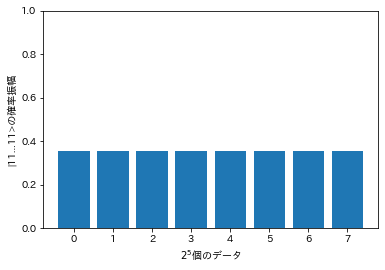

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]
作成したアダマールゲート


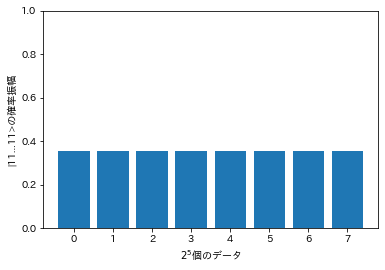

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


In [18]:
# 通常のアダマール演算子を作成し、 初期化した3量子ビットに作用
Hadamard = make_Hadamard(3)
state1 = QuantumState(3)
state1.set_zero_state()
Hadamard.update_quantum_state(state1)
print('通常のアダマールゲート')
show_distribution(state1, 3)
print(state1.get_vector())

# アダマール演算子と同じ振る舞いをするよう作成した回転ゲートを、
# 初期化した3量子ビットに作用
revolution_Hadamard = make_revolution_Hadamard(3)
state2 = QuantumState(3)
state2.set_zero_state()
revolution_Hadamard.update_quantum_state(state2)
print("作成したアダマールゲート")
show_distribution(state2, 3)

print(state2.get_vector())


どのくらいの誤差があるか調べる。

In [19]:
state1.get_vector() == state2.get_vector()
# 誤差
absolute_error_array = []
relative_error_array = []
for i in range(len(state1.get_vector())):
    absolute_error = state2.get_vector()[i] - state1.get_vector()[i]
    absolute_error_array.append(absolute_error)
    relative_error = absolute_error / state1.get_vector()[i]
    relative_error_array.append(relative_error)

print(f'絶対誤差：{absolute_error_array}')
print(f'相対誤差：{relative_error_array}')


絶対誤差：[(1.6653345369377348e-16+0j), (1.1102230246251565e-16+0j), (1.1102230246251565e-16+0j), (5.551115123125783e-17+0j), (1.1102230246251565e-16+0j), (5.551115123125783e-17+0j), (5.551115123125783e-17+0j), 0j]
相対誤差：[(4.710277376051326e-16+0j), (3.140184917367551e-16+0j), (3.140184917367551e-16+0j), (1.5700924586837754e-16+0j), (3.140184917367551e-16+0j), (1.5700924586837754e-16+0j), (1.5700924586837754e-16+0j), 0j]


## 任意の回転ゲートを使用してグローバーアルゴリズムを行う。
アダマール演算子と同じ振る舞いをする任意の回転ゲートを使用してグローバーアルゴリズムを行う。

In [20]:
result = []
def revolution_grover(nqubits, operate_times):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    # Hadamard = make_Hadamard(nqubits)
    Hadamard = make_revolution_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)


    max_k = np.argmax(result)
    return  result, max_k



[0.3535533905932737, 0.883883476483184, 0.9722718241315019, 0.5745242597140691, 0.1104854345603978]


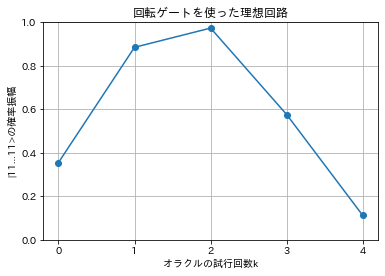

In [21]:
result, max_k = revolution_grover(nqubits, times)
print(result)
line_graph(result, '回転ゲートを使った理想回路')

In [22]:

grover_result = grover(nqubits, times)
print(grover_result)
print(result)

for i in range(len(grover_result)):
    hoge = abs(result[i] - grover_result[i])
    print(f'絶対誤差：{hoge}')


maximal probability 9.722718e-01 is obtained at k = 2
([0.3535533905932737, 0.8838834764831837, 0.9722718241315015, 0.5745242597140687, 0.11048543456039785], 2, 0.9722718241315015)
[0.3535533905932737, 0.883883476483184, 0.9722718241315019, 0.5745242597140691, 0.1104854345603978]
絶対誤差：[0.         0.53033009 0.61871843 0.22097087 0.24306796]
絶対誤差：1.116116523516816
絶対誤差：4.440892098500626e-16


## 作成した回転ゲートをずらしていく

作成した回転ゲートのy軸をずらしていく。
変数`delta`には$\theta$に加える角度を示す

In [23]:
def make_noisy_Hadamard(nqubits, delta):
    U_3 = QuantumCircuit(nqubits)
    THETA = np.pi/2
    PHI = 0
    LAMBDA = np.pi
    # 全てのqubitにゲートを作用
    for i in range(nqubits):
        control_index = i
        U_3.add_gate(U3(control_index, THETA + delta, PHI, LAMBDA))
    return U_3

In [24]:
def noisy_grover(nqubits, operate_times, delta):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    # Hadamard = make_revolution_Hadamard(nqubits)
    Hadamard = make_noisy_Hadamard(nqubits, delta)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)

    max_k = np.argmax(result)
    return  result, max_k, result[max_k]


### $\delta = 0$ ~ $2\pi$
実際に、$\delta = 0$~$2\pi$を$\theta$に加える

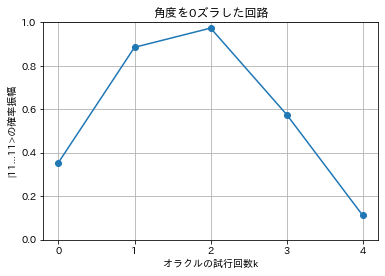

maximal probability 9.722718e-01 is obtained at k = 2
理想値k_theoryとの差:0
実験値kの時の確率：9.722718e-01
理想値k_theoryの時の確率:9.722718e-01


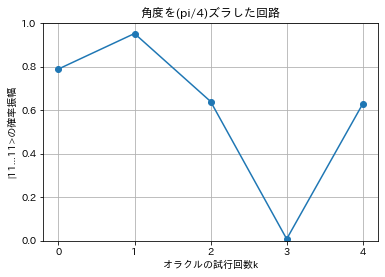

maximal probability 9.519009e-01 is obtained at k = 1
理想値k_theoryとの差:-1
実験値kの時の確率：9.519009e-01
理想値k_theoryの時の確率:6.392708e-01


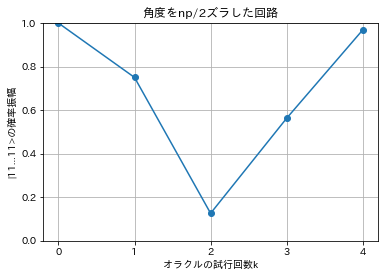

maximal probability 1.000000e+00 is obtained at k = 0
理想値k_theoryとの差:-2
実験値kの時の確率：1.000000e+00
理想値k_theoryの時の確率:1.250000e-01


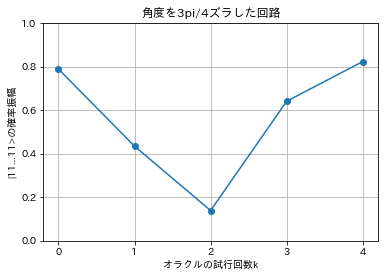

maximal probability 8.230062e-01 is obtained at k = 4
理想値k_theoryとの差:2
実験値kの時の確率：8.230062e-01
理想値k_theoryの時の確率:1.377029e-01


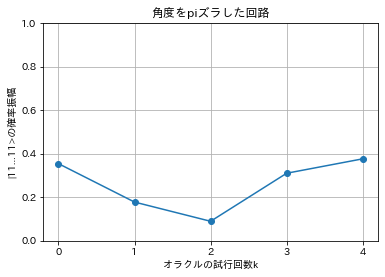

maximal probability 3.756505e-01 is obtained at k = 4
理想値k_theoryとの差:2
実験値kの時の確率：3.756505e-01
理想値k_theoryの時の確率:8.838835e-02


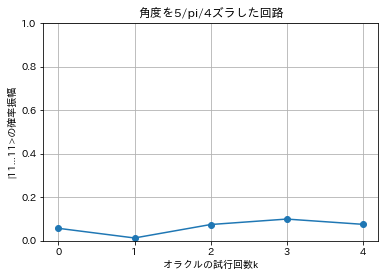

maximal probability 9.857256e-02 is obtained at k = 3
理想値k_theoryとの差:1
実験値kの時の確率：9.857256e-02
理想値k_theoryの時の確率:7.345292e-02


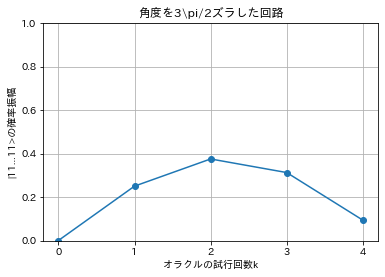

maximal probability 3.750000e-01 is obtained at k = 2
理想値k_theoryとの差:0
実験値kの時の確率：3.750000e-01
理想値k_theoryの時の確率:3.750000e-01


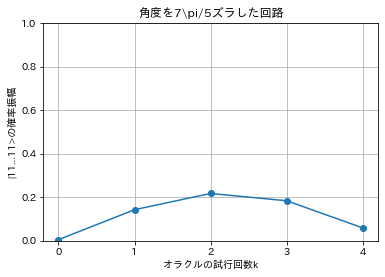

maximal probability 2.163504e-01 is obtained at k = 2
理想値k_theoryとの差:0
実験値kの時の確率：2.163504e-01
理想値k_theoryの時の確率:2.163504e-01


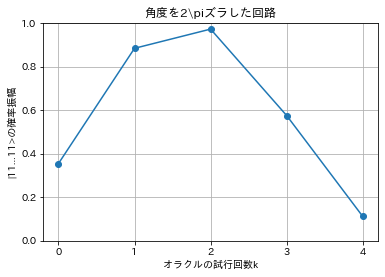

maximal probability 9.722718e-01 is obtained at k = 2
理想値k_theoryとの差:0
実験値kの時の確率：9.722718e-01
理想値k_theoryの時の確率:9.722718e-01


In [25]:
# noises = [-np.pi, -(np.pi*3 / 4), -(np.pi / 2), -(np.pi / 4), 0, (np.pi / 4), (np.pi / 2), np.pi*3 / 4, np.pi]
noises = [0, (np.pi / 4), (np.pi / 2), ((np.pi*3) / 4), np.pi, ((np.pi * 5)/4), ((np.pi*3)/2), ((np.pi*7)/5), 2*np.pi]
noises_title = ['0', '(pi/4)', 'np/2', '3pi/4', 'pi', '5/pi/4', '3\pi/2', '7\pi/5', '2\pi']

p_kth_array = []

for i in range(len(noises)):
    result, max_k, p_k = noisy_grover(nqubits, times, noises[i])

    line_graph(result, f'角度を{noises_title[i]}ズラした回路')
    # print(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')
    print(f'理想値k_theoryとの差:{max_k - k_theory}')
    print(f'実験値kの時の確率：{result[max_k]:5e}')
    print(f'理想値k_theoryの時の確率:{result[k_theory]:5e}')
    p_kth_array.append(result[k_theory])

9


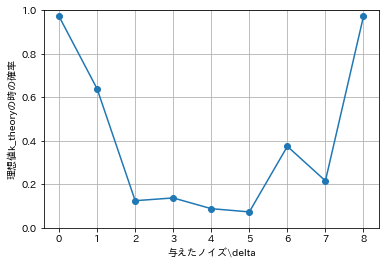

In [26]:


plt.xlabel('与えたノイズ\delta')
plt.ylabel('理想値k_theoryの時の確率')
plt.ylim(0, 1)
# plt.xticks(noises)
plt.grid()
print(len(p_kth_array))
plt.plot(p_kth_array, "o-")
